In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from enum import Enum
import math

def find_nearest_point(point_list, x, y):
    target_point = Point(x, y)
    min_distance = math.inf
    nearest_point = None

    for px, py in point_list:
        distance = target_point.distance(Point(px, py))
        if distance < min_distance:
            min_distance = distance
            nearest_point = (px, py)

    return nearest_point

shapefile_path = "data/buildings.shp"
simplified_shapefile_path = "data/simplified.shp"
output_csv_path = "output.csv"

# enumeration for action_type
class ActionType(Enum):
    Keep = 0
    Move = 1
    Remove = 2

# Read the simplified shapefile
simplified_gdf = gpd.read_file(simplified_shapefile_path)
simplified_gdf = simplified_gdf.to_crs(epsg=3857)

# dictionary to store the simplified polygons' vertices
simplified_coords = {}

for i, geometry in enumerate(simplified_gdf['geometry']):
    coords = list(geometry.exterior.coords)[:-1]  # Exclude the last coordinate
    simplified_coords[i + 1] = coords

# Read the main shapefile and reproject to EPSG:3857
gdf = gpd.read_file(shapefile_path)
gdf = gdf.to_crs(epsg=3857)

# DataFrame to store the vertex information
vertex_data = []

# Define the tolerance in meters (10 centimeters)
tolerance = 0.1

for i, geometry in enumerate(gdf['geometry']):
    polygon_id = i + 1

    if geometry.geom_type == 'Polygon':
        coordinates = list(geometry.exterior.coords)[:-1]  # Exclude the last coordinate
    elif geometry.geom_type == 'MultiPolygon':
        coordinates = [list(poly.exterior.coords)[:-1] for poly in geometry]
    else:
        continue

    simplified_polygon_coords = simplified_coords[polygon_id]
    
    for i, (x, y) in enumerate(coordinates):
        vertex = Point(x, y)
        
        action_type = ActionType.Remove
        move_position = None
        
        for coord in simplified_polygon_coords[:]:
            simplified_vertex = Point(coord)
            if vertex.distance(simplified_vertex) <= tolerance:
                simplified_polygon_coords.remove(coord)
                action_type = ActionType.Keep
                break

        vertex_data.append({
            'polygon_id': polygon_id,
            'x': x,
            'y': y,
            'action_type': action_type.value,
            'move_position': move_position
        })

    for simplified_coord in simplified_polygon_coords:
        nearest_original_coord = find_nearest_point(coordinates, simplified_coord[0], simplified_coord[1])

        update_row = next(row for row in vertex_data if row['polygon_id'] == polygon_id and row['x'] == nearest_original_coord[0] and row['y'] == nearest_original_coord[1])
        update_row['action_type'] = ActionType.Move.value
        update_row['move_position'] = simplified_coord

# Create the DataFrame with all the columns
df = pd.DataFrame(vertex_data, columns=['polygon_id', 'x', 'y', 'action_type', 'move_position'])

df.head(30)

,polygon_id,x,y,action_type,move_position
0,1,1.515470e+06,6.891502e+06,1,"(1515469.7188671685, 6891502.730517961)"
1,1,1.515489e+06,6.891507e+06,2,None
2,1,1.515488e+06,6.891511e+06,2,None
3,1,1.515496e+06,6.891513e+06,2,None
4,1,1.515497e+06,6.891510e+06,2,None
5,1,1.515515e+06,6.891515e+06,1,"(1515514.9522044258, 6891515.606054059)"
6,1,1.515521e+06,6.891493e+06,0,None
7,1,1.515476e+06,6.891480e+06,0,None
8,2,1.508984e+06,6.893094e+06,1,"(1508983.853250296, 6893093.640235925)"
9,2,1.508982e+06,6.893081e+06,2,None


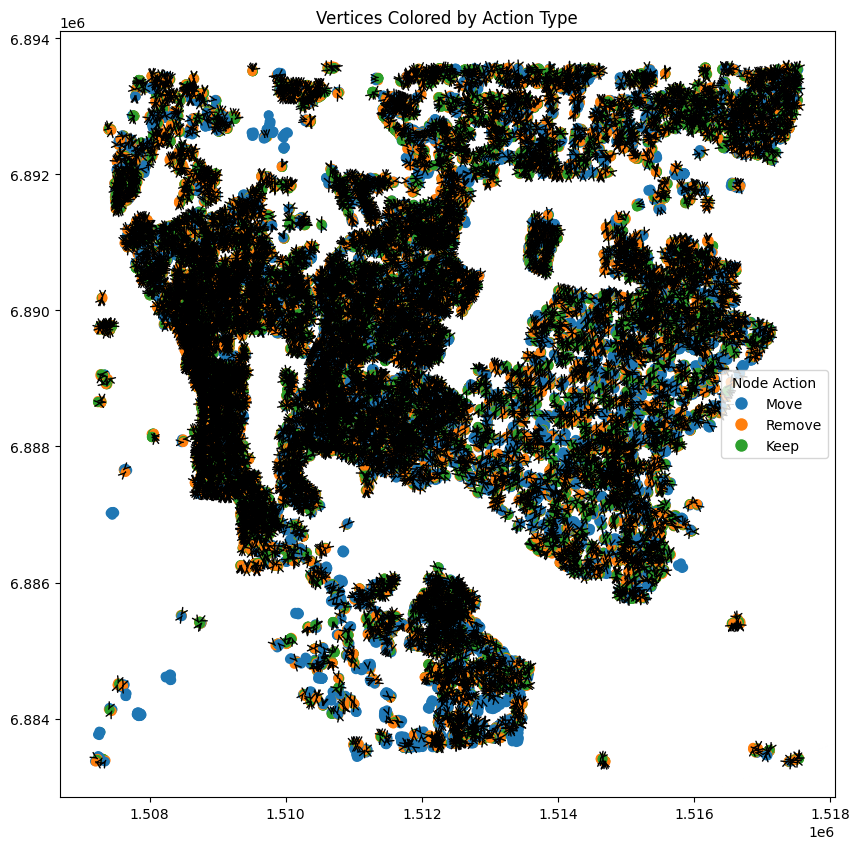

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

geometry = gpd.points_from_xy(df['x'], df['y'])
gdf_display = gpd.GeoDataFrame(df, geometry=geometry)

# Set up a distinct color map for action_type
cmap = ListedColormap(plt.cm.tab10.colors[:len(df['action_type'].unique())])

# Plot the map with colored vertices
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='gray', alpha=0.5)
simplified_gdf.plot(ax=ax, color='none', edgecolor='gray', linestyle='dotted', linewidth=2)
gdf_display.plot(column='action_type', cmap=cmap, ax=ax)

legend_handles = []
for action_type, color in zip(df['action_type'].unique(), cmap.colors):
    display_string = ActionType(action_type).name
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=display_string))

ax.legend(handles=legend_handles, title='Node Action')

# Add arrows for ActionType.Move nodes
for index, row in df.iterrows():
    if row['action_type'] == ActionType.Move.value:
        ax.annotate('', xy=(row['move_position'][0], row['move_position'][1]), xytext=(row['x'], row['y']),
                    arrowprops=dict(arrowstyle="->", color='black', linewidth=1))

plt.title("Vertices Colored by Action Type")
plt.show()

In [4]:
df.to_csv('buildings_simpl_action.csv')